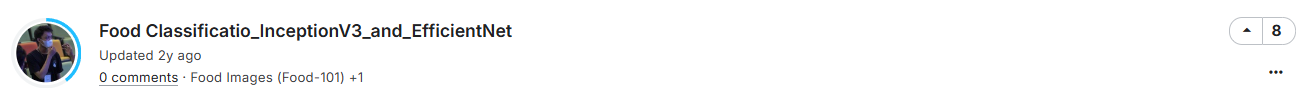

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import sys
import matplotlib.pyplot as plt


import tensorflow_hub as hub

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense, MaxPooling2D, BatchNormalization, Input, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
DATA_PATH = r"D:\code_study\ML_CODE\dataSets\Classification\Food_11_image_dataset\archive"
DATA_PATH = DATA_PATH.replace("\\", "/")
TRAIN_DATA_DIR = DATA_PATH + "/training"
TEST_DATA_DIR = DATA_PATH + "/validation"
VAL_DATA_DIR = DATA_PATH + "/evaluation"
BATCH_SIZE=32
OUTPUT_FIGURE_DIR = "./"

In [3]:
def train_val_generators(TRAIN_DIR, TEST_DIR,VAL_DIR, NUM_BATCHES):
    """

    :param DATA_DIR: Directory of the datasets was taken from (string)
    :param SPLIT_SIZE: Split size of test set. (float)
    :param NUM_BATCHES: Amount of batch size
    :return:
    """
    
    
    train_generator = tf.keras.preprocessing.image_dataset_from_directory(directory=TRAIN_DIR,
                                                  batch_size=NUM_BATCHES,
                                                  label_mode='categorical',
                                                  image_size=(224, 224),
                                                    

    )

    test_generator = tf.keras.preprocessing.image_dataset_from_directory(directory=TEST_DIR,
                                                       batch_size=NUM_BATCHES,
                                                       label_mode='categorical',
                                                       image_size=(224, 224))

    validation_generator = tf.keras.preprocessing.image_dataset_from_directory(directory=VAL_DIR,
                                                       batch_size=NUM_BATCHES,
                                                       label_mode='categorical',
                                                       image_size=(224, 224))

    return train_generator,test_generator, validation_generator

In [4]:
train_ds, test_ds, val_ds = train_val_generators(TRAIN_DATA_DIR, TEST_DATA_DIR,VAL_DATA_DIR, BATCH_SIZE)

Found 9866 files belonging to 11 classes.
Found 3430 files belonging to 11 classes.
Found 3347 files belonging to 11 classes.


In [5]:
OPTIMIZER = 'adam'
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy']

In [6]:
def plot_accuracy(history, output_dir, model_name):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig(f"{output_dir}/accuracy_{model_name}")
    plt.show()
    
def plot_loss(history, output_dir, model_name):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig(f"{output_dir}/loss_{model_name}")
    plt.show()

In [7]:
data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name='data_augmentation')

In [8]:
# Set checkpoint path

checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', # Save for every epochs
                                                         verbose=1
                                                         )

In [9]:
# Setup input shape and base model
input_shape = (224, 224, 3)

base_model = tf.keras.applications.InceptionV3(include_top=False)
base_model.trainable =  False

# Create inputt layers
inputs = tf.keras.Input(shape=input_shape)

# Data augmentation
x = data_augmentation(inputs)

# Give base model input after augmentation 
x = base_model(x, training=False)

# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model_inception_1 =  Model(inputs, outputs)

# Compile
model_inception_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model_inception_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                22539     
Total params: 21,825,323
Trainable params: 22,539
Non-trainable params: 21,802,784
_________________________________________________________________


In [10]:
csv_logger_feature_extraction = tf.keras.callbacks.CSVLogger("./LOG_CSV_INCEPTION_FEATURE_EXTRACTION.log")
csv_logger_fine_tune = tf.keras.callbacks.CSVLogger("./LOG_CSV_INCEPTION_FINE_TUNE.log")

In [11]:
initial_epochs = 15

history_model_inception_1_feature_extraction = model_inception_1.fit(train_ds, epochs=initial_epochs, validation_data=test_ds, callbacks=[csv_logger_feature_extraction, checkpoint_callback])

Epoch 1/15
309/309 [==============================] - 391s 1s/step - loss: 14.4920 - accuracy: 0.1695 - val_loss: 6.8503 - val_accuracy: 0.2297

Epoch 00001: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
Epoch 2/15
309/309 [==============================] - 168s 537ms/step - loss: 8.6812 - accuracy: 0.2017 - val_loss: 6.4874 - val_accuracy: 0.2388

Epoch 00002: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
Epoch 3/15
309/309 [==============================] - 127s 409ms/step - loss: 8.4197 - accuracy: 0.2028 - val_loss: 8.3828 - val_accuracy: 0.1886

Epoch 00003: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
Epoch 4/15
309/309 [==============================] - 119s 383ms/step - loss: 8.5675 - accuracy: 0.2161 - val_loss: 7.5988 - val_accuracy: 0.1834

Epoch 00004: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
Epoch 5/15
309/309 [==============================] - 104s 332ms/step - loss: 6.89

Text(0.5, 1.0, 'Model Inception Exp 1')

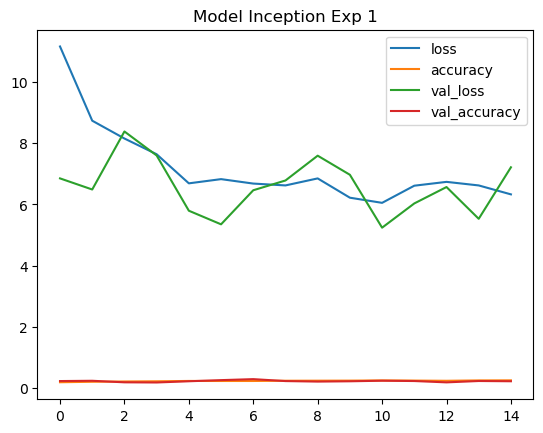

In [12]:
pd.DataFrame(history_model_inception_1_feature_extraction.history).plot()
plt.title("Model Inception Exp 1")

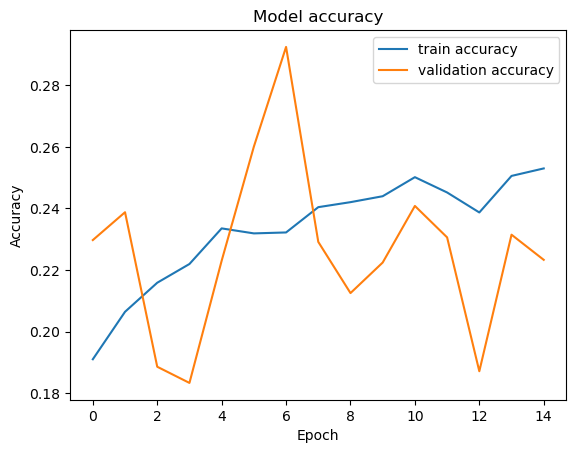

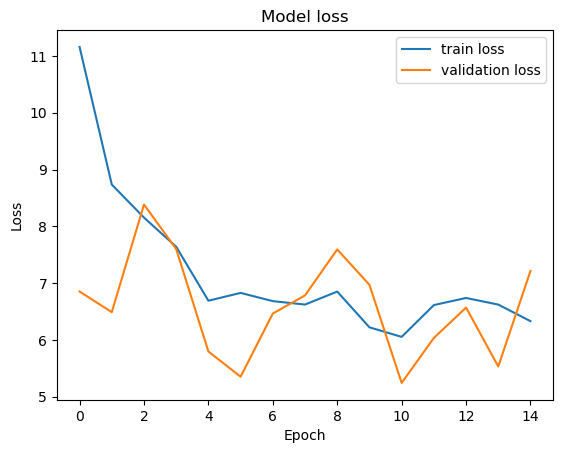

In [13]:
plot_accuracy(history_model_inception_1_feature_extraction,".", 'model_inception_1_20epoch_accuracy')
plot_loss(history_model_inception_1_feature_extraction, ".", 'model_inception_1_20epoch_loss')

In [14]:
for layer in model_inception_1.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000217DBBAE5C8> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000217D5423688> True
<tensorflow.python.keras.engine.functional.Functional object at 0x00000217DC6B5A48> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x00000217F59677C8> True
<tensorflow.python.keras.layers.core.Dense object at 0x00000217F5956E08> True


In [15]:
for i, layer in enumerate(model_inception_1.layers[2].layers):
    print(layer.name, layer.trainable)

input_1 False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed0 False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
batch_normalization_13 False
batch_normalization_16 False
activati

In [16]:
# Set all the trainable back to True
base_model.trainable = True

# Free all the layers except for the last 10 layers:
for layer in base_model.layers[:-10]:
    layer.trainable = False
    
# Recompile the model 
model_inception_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         metrics=['accuracy'])

In [17]:
for layer in model_inception_1.layers:
    print(layer.name, layer.trainable)

input_2 True
data_augmentation True
inception_v3 True
global_average_pooling2d True
dense True


In [18]:
# Fine tune for another 10 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model before fine tuning butt with more trainble layers)
history_model_inception_1_fine_tune = model_inception_1.fit(train_ds,
                                                            epochs=fine_tune_epochs,
                                                            validation_data=test_ds,
                                                            initial_epoch=history_model_inception_1_feature_extraction.epoch[-1],
                                                            callbacks=[csv_logger_fine_tune]
                                                           )

Epoch 15/25
309/309 [==============================] - 80s 246ms/step - loss: 3.7229 - accuracy: 0.2999 - val_loss: 3.1293 - val_accuracy: 0.2971
Epoch 16/25
309/309 [==============================] - 73s 234ms/step - loss: 3.0612 - accuracy: 0.3098 - val_loss: 3.1718 - val_accuracy: 0.2942
Epoch 17/25
309/309 [==============================] - 74s 236ms/step - loss: 2.9799 - accuracy: 0.2981 - val_loss: 2.9664 - val_accuracy: 0.2866
Epoch 18/25
309/309 [==============================] - 73s 235ms/step - loss: 2.9133 - accuracy: 0.3010 - val_loss: 2.7546 - val_accuracy: 0.3140
Epoch 19/25
309/309 [==============================] - 76s 243ms/step - loss: 2.8304 - accuracy: 0.3056 - val_loss: 2.9906 - val_accuracy: 0.2843
Epoch 20/25
309/309 [==============================] - 71s 227ms/step - loss: 2.8461 - accuracy: 0.3029 - val_loss: 2.6590 - val_accuracy: 0.3140
Epoch 21/25
309/309 [==============================] - 72s 232ms/step - loss: 2.7481 - accuracy: 0.3124 - val_loss: 2.8198 -

In [19]:
# Let's create a function to compare training histories
def compare_historys(name, original_history, new_history, initial_epochs=15):
    """
    Compare two TensorFlow History objects
      """

  # Get original history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']

    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']

  # Combine original history metrics with new_history
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']

    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']

  # Make plots for accuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Val Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.savefig(f"./plot_history_{name}_accuracy")
    plt.show()


  # Make plots
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Val Loss')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')
    plt.savefig(f"./plot_history_{name}_loss")
    plt.show()
    

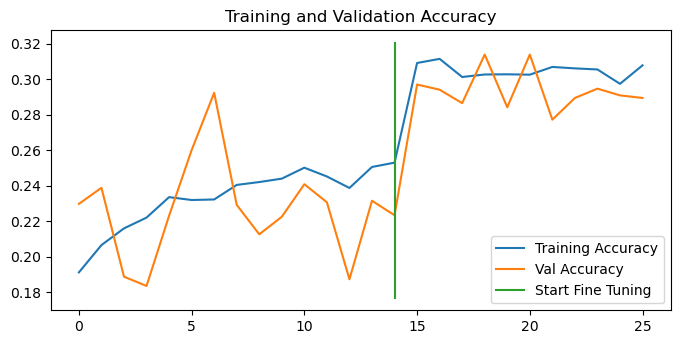

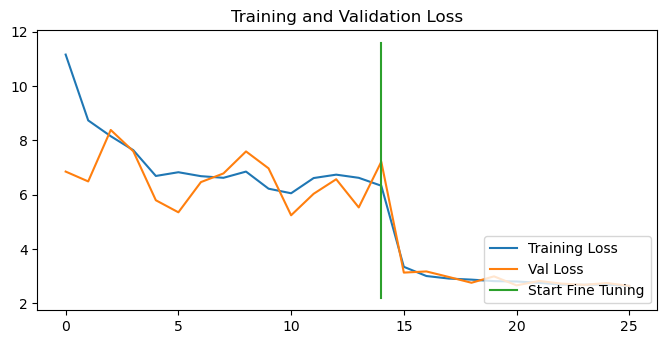

In [20]:
compare_historys("inception_v3", history_model_inception_1_feature_extraction, history_model_inception_1_fine_tune)

In [21]:
# Setup input shape and base model
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable =  False

# Create inputt layers
inputs = tf.keras.Input(shape=input_shape)

# Data augmentation
x = data_augmentation(inputs)

# Give base model input after augmentation 
x = base_model(x, training=False)

# x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model_efficientnet_1 =  Model(inputs, outputs)

# Compile
model_efficientnet_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model_efficientnet_1.summary()

258080768/258076736 [==============================] - 516s 2us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                28171     
Total params: 64,125,858
Trainable params: 28,171
Non-trainable params: 64,097,687
_________________________________________________________________


In [22]:
model_efficientnet_1.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

csv_logger_feature_extraction = tf.keras.callbacks.CSVLogger("./LOG_CSV_EFFICIENTNETB7_FEATURE_EXTRACTION.log")
csv_logger_fine_tune = tf.keras.callbacks.CSVLogger("./LOG_CSV_EFFICIENTNETB7_FINE_TUNE.log")

model_efficientnet_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                28171     
Total params: 64,125,858
Trainable params: 28,171
Non-trainable params: 64,097,687
_________________________________________________________________


In [23]:
history_model_efficientnet_1_feature_extraction = model_efficientnet_1.fit(train_ds, 
                                                                     epochs=initial_epochs,
                                                                     validation_data=test_ds, 
                                                                     callbacks=[csv_logger_feature_extraction])

Epoch 1/15
309/309 [==============================] - 384s 1s/step - loss: 1.2504 - accuracy: 0.6156 - val_loss: 0.6290 - val_accuracy: 0.7959
Epoch 2/15
309/309 [==============================] - 289s 932ms/step - loss: 0.6488 - accuracy: 0.7934 - val_loss: 0.5402 - val_accuracy: 0.8312
Epoch 3/15
309/309 [==============================] - 281s 909ms/step - loss: 0.5688 - accuracy: 0.8135 - val_loss: 0.5132 - val_accuracy: 0.8411
Epoch 4/15
309/309 [==============================] - 257s 832ms/step - loss: 0.5114 - accuracy: 0.8358 - val_loss: 0.5033 - val_accuracy: 0.8405
Epoch 5/15
309/309 [==============================] - 248s 802ms/step - loss: 0.4956 - accuracy: 0.8344 - val_loss: 0.4798 - val_accuracy: 0.8501
Epoch 6/15
309/309 [==============================] - 235s 761ms/step - loss: 0.4838 - accuracy: 0.8378 - val_loss: 0.4724 - val_accuracy: 0.8510
Epoch 7/15
309/309 [==============================] - 242s 781ms/step - loss: 0.4480 - accuracy: 0.8504 - val_loss: 0.4641 - va

Text(0.5, 1.0, 'Model EfficientNet Exp 1')

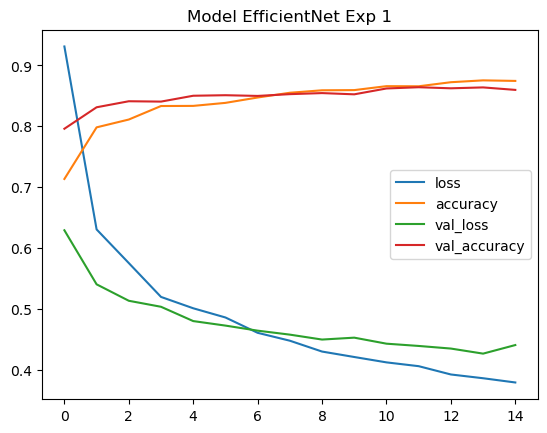

In [24]:
pd.DataFrame(history_model_efficientnet_1_feature_extraction.history).plot()
plt.title("Model EfficientNet Exp 1")

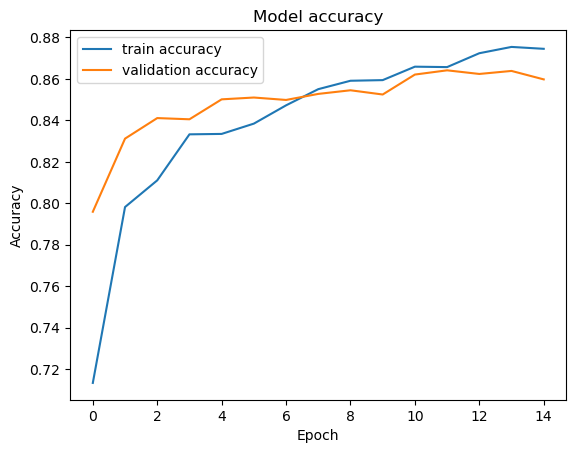

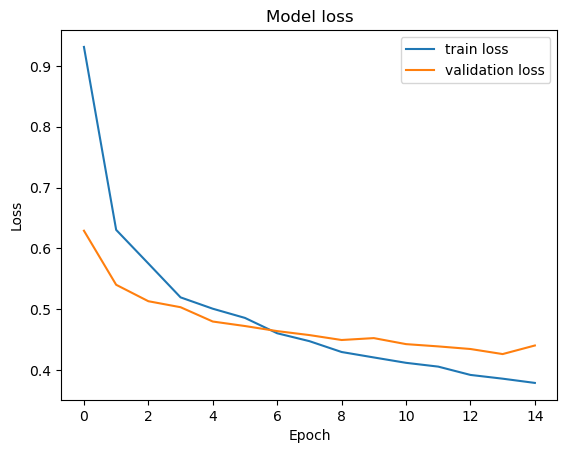

In [25]:
plot_accuracy(history_model_efficientnet_1_feature_extraction,".", 'model_efficientnet_1_15epoch_accuracy')
plot_loss(history_model_efficientnet_1_feature_extraction, ".", 'model_efficientnet_1_15epoch_loss')

In [26]:
for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_3 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block1c_dwconv False
block1c_bn False
block1c_activation False
block1c_se_squeeze False
block1c_se_reshape False
block1c_se_reduce False
block1c_se_expand False
block1c_se_excite False
block1c_project_conv False
block1c_project_bn False
block1c_drop False
block1c_add False
block1d_dwconv False
block1d_bn False
block1d_activation False
block1d_se_squeeze False
block

In [27]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

model_efficientnet_1.compile(loss='categorical_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                            metrics=['accuracy'])

In [28]:
# Fine tune for another 10 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model before fine tuning butt with more trainble layers)
history_model_efficientnet_1_fine_tune = model_inception_1.fit(train_ds,
                                                            epochs=fine_tune_epochs,
                                                            validation_data=test_ds,
                                                            initial_epoch=history_model_efficientnet_1_feature_extraction.epoch[-1],
                                                            callbacks=[csv_logger_fine_tune]
                                                           )

Epoch 15/25
309/309 [==============================] - 59s 191ms/step - loss: 2.5704 - accuracy: 0.3082 - val_loss: 2.6344 - val_accuracy: 0.2910
Epoch 16/25
309/309 [==============================] - 57s 185ms/step - loss: 2.5547 - accuracy: 0.3103 - val_loss: 2.6445 - val_accuracy: 0.2942
Epoch 17/25
309/309 [==============================] - 58s 186ms/step - loss: 2.5969 - accuracy: 0.3045 - val_loss: 2.8072 - val_accuracy: 0.2746
Epoch 18/25
309/309 [==============================] - 57s 183ms/step - loss: 2.5790 - accuracy: 0.3069 - val_loss: 2.6373 - val_accuracy: 0.2930
Epoch 19/25
309/309 [==============================] - 57s 182ms/step - loss: 2.5186 - accuracy: 0.3107 - val_loss: 2.8293 - val_accuracy: 0.2834
Epoch 20/25
309/309 [==============================] - 56s 179ms/step - loss: 2.5561 - accuracy: 0.3092 - val_loss: 2.4966 - val_accuracy: 0.2997
Epoch 21/25
309/309 [==============================] - 58s 185ms/step - loss: 2.5247 - accuracy: 0.3044 - val_loss: 2.5072 -

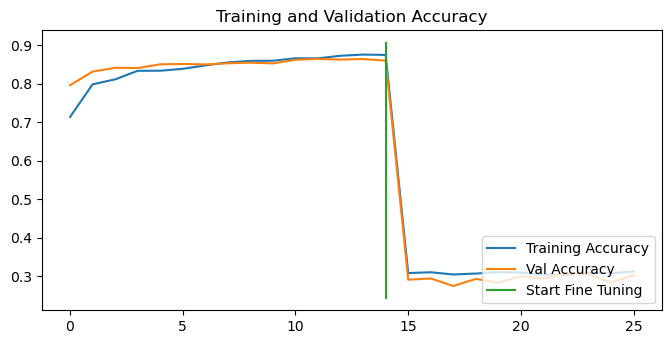

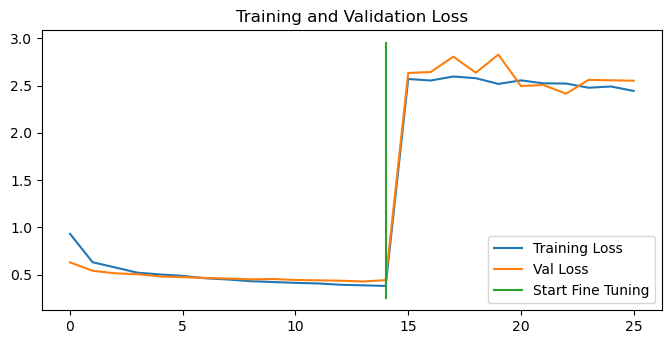

In [29]:
compare_historys("efficientnet", history_model_efficientnet_1_feature_extraction, history_model_efficientnet_1_fine_tune)